# Classification Model
* <b>File Name</b>                          : Reference_implementation
* <b>Date of creation(dd-mm-yyyy)</b>       : 21-01-2023
* <b>Author Name/Dept</b>                   : AIShield
* <b>Organization</b>                       : BGSW
* <b>Description</b>                        : Source Code of reference implementation
* <b>Copyright</b>                          : Copyright 2022 Bosch Global Software Technologies Private Limited. All Rights Reserved.

### Metadata
* Dataset: mnist
* Size of training set: 54,000
* Size of testing set : 10,000
* Size of training set: 6,000
* Number of class : 10
* Original Model: CNN

### Outcomes
* Accuracy of model: 0.99

In [ ]:
<a target="_blank" href="https://colab.research.google.com/github/bosch-aisecurity-aishield/Reference-Implementations/blob/main/Product_Taskpair_wise/Image_Classification/Poisoning/Poisoning_Reference%20Implementation_MNIST.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 1.0 Install and Import Libraries

In [ ]:
"""
Description: commands to install all the packages, remove comments to install all the libraries
"""
# !pip install numpy==1.22
# !pip install pandas==1.1.5
# !pip install matplotlib==3.5.1
# !pip install tensorflow==2.9.1
# !pip install scikit-learn==1.0.2
# !pip install requests==2.28.0
# !pip install zipp==3.7.0
# !pip install opencv-python

'\nDescription: commands to install all the packages, remove comments to install all the libraries\n'

In [ ]:
"""
Description: Import libraries
"""

import os
import cv2
import json
import time
import shutil
import copy
import zipfile 
import random
import requests
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, optimizers , Sequential
from sklearn.model_selection import train_test_split


# 2.0 Data Loading and Preprocessing

In [ ]:
'''
Description : Loading mnist dataset
'''
(X_train,y_train),(X_test,y_test)=datasets.mnist.load_data()

In [ ]:
'''
Description : Splitting data for validation
'''
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,stratify = y_train,test_size = 0.1,random_state = 42)

In [ ]:
'''
Description : Check size of dataset
'''
print("shape of x_train: ",X_train.shape)
print("shape of y_train: {}".format(y_train.shape))
print(f'shape of x_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')
print(f'shape of x_val: {X_val.shape}')
print(f'shape of y_val: {y_val.shape}')

shape of x_train:  (54000, 28, 28)
shape of y_train: (54000,)
shape of x_test: (10000, 28, 28)
shape of y_test: (10000,)
shape of x_val: (6000, 28, 28)
shape of y_val: (6000,)


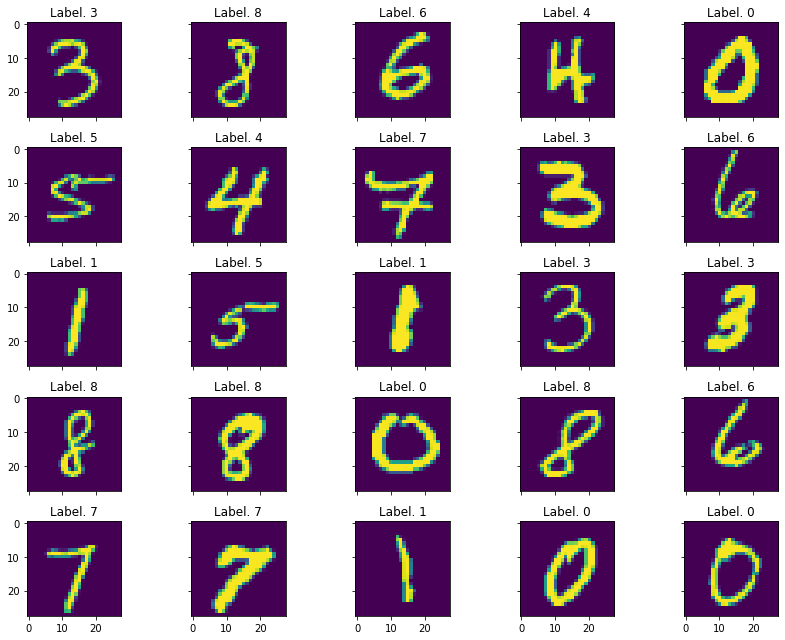

In [ ]:
'''
Description: Visualize few random data sample
'''
rows=5

random_indices=random.sample(range(X_train.shape[0]),rows*rows)
sample_images=X_train[random_indices,:]
sample_labels=y_train[random_indices]

fig,axs=plt.subplots(nrows=rows,ncols=rows,figsize=(12,9),sharex=True,sharey=True)
for i in range(rows*rows):
    subplot_row=i // rows
    subplot_col=i % rows
    axs[subplot_row,subplot_col].imshow(sample_images[i,:])
    axs[subplot_row,subplot_col].set_title("Label. %d" % sample_labels[i])
plt.tight_layout()

In [ ]:
'''
Description : Set num_classes and input shape 
'''
img_row,img_col,channel=28,28,1
num_classes=10
input_shape=(img_row,img_col,channel)

In [ ]:
"""
Description: Normalizing and reshaping the data
"""
X_train = X_train.reshape(-1,*input_shape)/255.0
X_val =  X_val.reshape(-1,*input_shape)/255.0
X_test =  X_test.reshape(-1,*input_shape)/255.0

In [ ]:
"""
Description : Convert label to one hot encoder
"""
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)


# 3.0 Model Development and Training


In [ ]:
def make_directory(directory):
    """
    create directory

    Parameters
    ----------
    directorys : list containing the directorys path to create 
    Returns
    -------
    None.

    """
    for d in directory:
        if os.path.isdir(d):
            print("directory {} already exist".format(d))
        if os.path.isdir(d)==False:
            os.mkdir(path=d)
            print("directory {} created successfully".format(d))

In [ ]:
def delete_directory(directorys):
    """
    delete directory 

    Parameters
    ----------
    directorys : list containing the directorys to deleate along with all the files

    Returns
    -------
    None.

    """
    if len(directorys)>=1:
        for d in directorys:
            if os.path.isdir(d):
                try:
                    if os.path.isfile(d):
                        os.remove(path=d)
                    else:
                        shutil.rmtree(path=d)
                        print("Removed: {}".format(d))
                except:
                    print("Failed to removed: {}".format(d))
            else:
                print("Failed to removed: {}".format(d))
                

In [ ]:
def make_archive(base_name,root_dir,base_dir = "",zip_format='zip', is_dir=False):
    """
    created zip for given folder

    Parameters
    ----------
    base_name : name of zip file
    root_dir : directory to archive/zip
    zip_format : zip or tar 
        DESCRIPTION. The default is 'zip'.

    Returns
    -------
    None.

    """
    if is_dir:
        shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir, base_dir = base_dir)
    else:
        shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir)
    

In [ ]:
"""
Description : Create data, model and label folder
"""
val_data_path=os.path.join(os.getcwd(),"val_data")
clean_model1_path=os.path.join(os.getcwd(),"clean_model1")
clean_model2_path=os.path.join(os.getcwd(),"clean_model2")
fine_tuned_model_path=os.path.join(os.getcwd(),"fine_tuned_model")
val_label_path=os.path.join(os.getcwd(),"val_label")
report_path = os.path.join(os.getcwd(), "reports")

#deleting folder
delete_directory(directorys=[val_data_path,clean_model1_path,clean_model2_path,fine_tuned_model_path,val_label_path,report_path])

#creating folder
make_directory([val_data_path,clean_model1_path,clean_model2_path,fine_tuned_model_path,val_label_path,report_path])

# # create sub folder
val_data_path_new = os.path.join(val_data_path,"val_data")
make_directory([val_data_path_new])

In [ ]:
"""
Description: Create model architecture
"""
def create_model():
    model = Sequential([
        layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
        layers.Conv2D(32, (5,5), padding='same', activation='relu'),
        layers.MaxPool2D(),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPool2D(strides=(2,2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  
    ])


    #Compile model
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss = 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

## 3.1 Clean Model 1

In [ ]:
"""
Description: Clean Model 1 summary
"""
clean_model1 = create_model()
clean_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

In [ ]:
"""
Description: Model architecture plot
"""
tf.keras.utils.plot_model(clean_model1,show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
"""
Description : Callbacks
"""
# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='clean_model1/clean_model1.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
# Early stopper
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,mode='min')

callbacks = [early_stop, checkpoint]


In [ ]:
"""
Description: Training model
"""
history = clean_model1.fit(X_train, y_train, validation_data = (X_test, y_test),epochs = 3, batch_size=64, verbose = 1 , callbacks = callbacks)

Epoch 1/3
844/844 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9244
Epoch 1: val_loss improved from inf to 0.04167, saving model to clean_model1\clean_model1.h5
844/844 [==============================] - 38s 32ms/step - loss: 0.2383 - accuracy: 0.9244 - val_loss: 0.0417 - val_accuracy: 0.9858
Epoch 2/3
844/844 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9746
Epoch 2: val_loss improved from 0.04167 to 0.03253, saving model to clean_model1\clean_model1.h5
844/844 [==============================] - 26s 31ms/step - loss: 0.0835 - accuracy: 0.9746 - val_loss: 0.0325 - val_accuracy: 0.9887
Epoch 3/3
844/844 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9822
Epoch 3: val_loss improved from 0.03253 to 0.02500, saving model to clean_model1\clean_model1.h5
844/844 [==============================] - 26s 31ms/step - loss: 0.0608 - accuracy: 0.9822 - val_loss: 0.0250 - val_accuracy: 0.9911


In [ ]:
"""
Description: Evaluate trained model
"""
loss,accuracy=clean_model1.evaluate(X_test, y_test)
print("* Loss: {} \n* Accuracy: {}".format(loss,accuracy))

313/313 [==============================] - 3s 10ms/step - loss: 0.0250 - accuracy: 0.9911
* Loss: 0.025004981085658073 
* Accuracy: 0.991100013256073


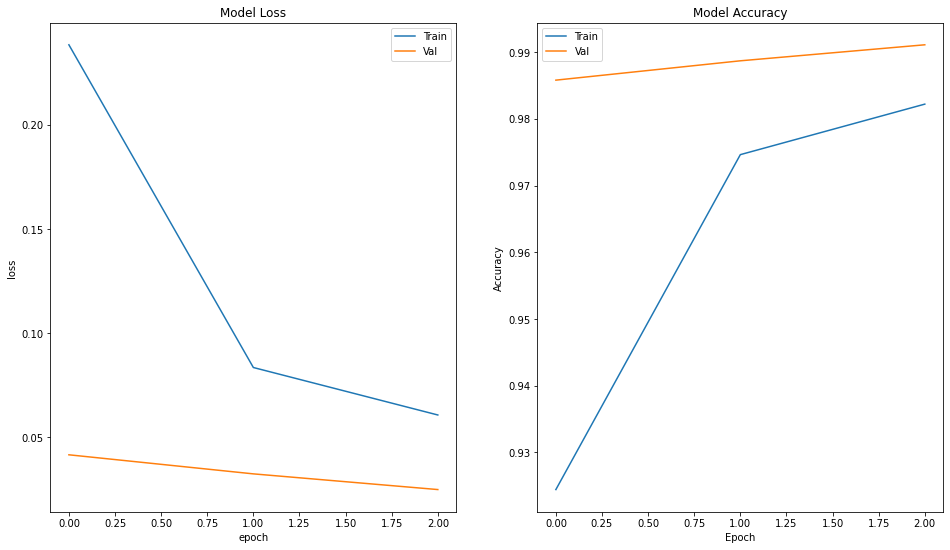

In [ ]:
"""
Description: Visualize model learning 
"""
fig, ax = plt.subplots(1, 2, figsize = (16, 9))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].legend(['Train', 'Val'], loc = 'best')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc = 'best')

plt.show()

## 3.2 Clean Model 2

In [ ]:
"""
Description: Clean Model 2 summary
"""
clean_model2 = create_model()
clean_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

In [ ]:
"""
Description: Model architecture plot
"""
tf.keras.utils.plot_model(clean_model2,show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
"""
Description : Callbacks
"""
# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='clean_model2/clean_model2.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
# Early stopper
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,mode='min')

callbacks = [early_stop, checkpoint]


In [ ]:
"""
Description: Training model
"""
history = clean_model2.fit(X_train, y_train, validation_data = (X_test, y_test),epochs = 3, batch_size=64, verbose = 1 , callbacks = callbacks)

Epoch 1/3
844/844 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.9247
Epoch 1: val_loss improved from inf to 0.04045, saving model to clean_model2\clean_model2.h5
844/844 [==============================] - 26s 29ms/step - loss: 0.2406 - accuracy: 0.9247 - val_loss: 0.0405 - val_accuracy: 0.9865
Epoch 2/3
843/844 [============================>.] - ETA: 0s - loss: 0.0814 - accuracy: 0.9762
Epoch 2: val_loss improved from 0.04045 to 0.03780, saving model to clean_model2\clean_model2.h5
844/844 [==============================] - 25s 29ms/step - loss: 0.0815 - accuracy: 0.9762 - val_loss: 0.0378 - val_accuracy: 0.9878
Epoch 3/3
843/844 [============================>.] - ETA: 0s - loss: 0.0590 - accuracy: 0.9827
Epoch 3: val_loss improved from 0.03780 to 0.02453, saving model to clean_model2\clean_model2.h5
844/844 [==============================] - 25s 29ms/step - loss: 0.0591 - accuracy: 0.9827 - val_loss: 0.0245 - val_accuracy: 0.9925


In [ ]:
"""
Description: Evaluate trained model
"""
loss,accuracy=clean_model2.evaluate(X_test, y_test)
print("* Loss: {} \n* Accuracy: {}".format(loss,accuracy))

313/313 [==============================] - 6s 19ms/step - loss: 0.0245 - accuracy: 0.9925
* Loss: 0.02452828735113144 
* Accuracy: 0.9925000071525574


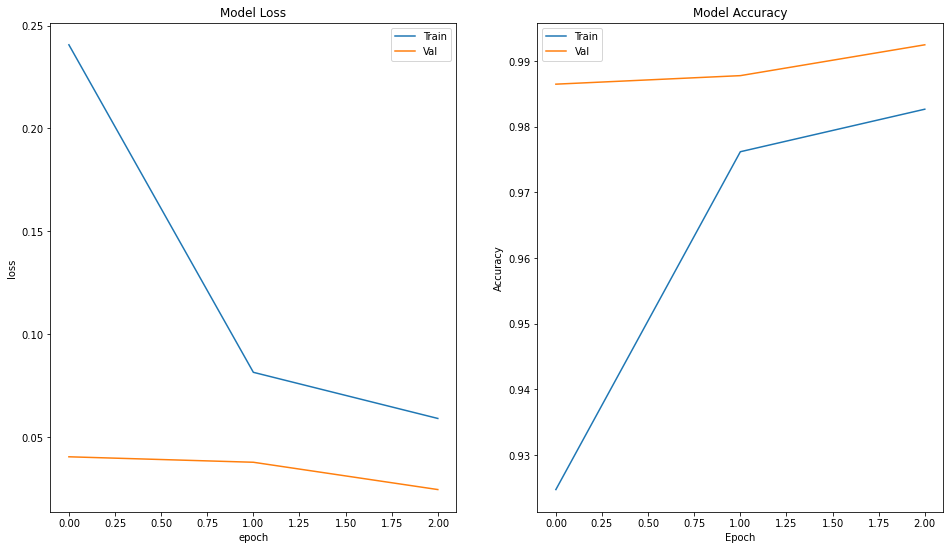

In [ ]:
"""
Description: Visualize model learning 
"""
fig, ax = plt.subplots(1, 2, figsize = (16, 9))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].legend(['Train', 'Val'], loc = 'best')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc = 'best')

plt.show()

## 3.3 Fine Poisoned Model

In [ ]:
"""
Description: Backdoor Poisoning Attack
""" 

class Backdoor():
    
    def __init__(self , pixel_value): # pixel_value is [0,1]
            self.pixel_value = pixel_value
            
    def add_pattern_bd(self, x: np.ndarray, distance: int = 2) -> np.ndarray:  
        """
        Augments a matrix by setting a checkboard-like pattern of values some distance away from the bottom-right
        edge to 1. Works for single images or a batch of images.
        :param x: N X W X H matrix or W X H matrix or N X W X H X C matrix, pixels will ne added to all channels
        :param distance: Distance from bottom-right walls.
        :param pixel_value: Value used to replace the entries of the image matrix.
        :return: Backdoored image.
        """
        x = np.array(x)
        shape = x.shape
        if len(shape) == 4:
            width, height = x.shape[1:3]
            x[:, width - distance, height - distance, :] = self.pixel_value
            x[:, width - distance - 1, height - distance - 1, :] = self.pixel_value
            x[:, width - distance, height - distance - 2, :] = self.pixel_value
            x[:, width - distance - 2, height - distance, :] = self.pixel_value
        elif len(shape) == 3:
            width, height = x.shape[:2]
            x[width - distance, height - distance, :] = self.pixel_value
            x[width - distance - 1, height - distance - 1, :] = self.pixel_value
            x[width - distance, height - distance - 2, :] = self.pixel_value
            x[width - distance - 2, height - distance, :] = self.pixel_value

        elif len(shape) == 2:
            width, height = x.shape
            x[width - distance, height - distance] = self.pixel_value
            x[width - distance - 1, height - distance - 1] = self.pixel_value
            x[width - distance, height - distance - 2] = self.pixel_value
            x[width - distance - 2, height - distance] = self.pixel_value
        else:
            raise ValueError("Invalid array shape: " + str(shape))
           

        return x




In [ ]:
"""
Description : Creating the Poisonied data by Posioning some percent of traning data. This is done by the adversary
"""

percent_poison = 0.05   # change this 
n_train = X_train.shape[0]
num_selection = int(percent_poison*n_train)
random_selection_indices = np.random.choice(n_train, num_selection)

X_train_poisoned = np.copy(X_train)
y_train_poisoned = np.copy(y_train)

target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]) # poisoinig to 9s 

bd = Backdoor((0.1))  
for i in random_selection_indices : 
    X_train_poisoned[i] , y_train_poisoned[i] = bd.add_pattern_bd(X_train_poisoned[i]), target
    
    
    
X_test_poisoned = np.copy(X_test)
y_test_poisoned = np.copy(y_test)

target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]) # poisoinig to 9s 

bd = Backdoor((0.1))  
for i in range(X_test_poisoned.shape[0]) : 
    X_test_poisoned[i] , y_test_poisoned[i] = bd.add_pattern_bd(X_test_poisoned[i]), target
    
    


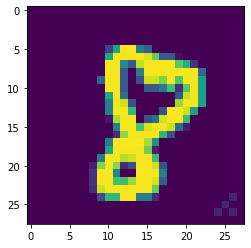

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
"""
Description : Visualizing Poisoned Samples
"""
plt.imshow(X_train_poisoned[random_selection_indices[1]])
plt.show()
print(y_train_poisoned[random_selection_indices[1]])

In [ ]:
"""
Description: Fine tuned model summary
"""
fine_tuned_model = create_model()
fine_tuned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        36928     
                                                      

In [ ]:
"""
Description: Model architecture plot
"""
tf.keras.utils.plot_model(fine_tuned_model,show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
"""
Description : Callbacks
"""
# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='fine_tuned_model/fine_tuned_model.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='auto')
# Early stopper
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,mode='min')

callbacks = [early_stop, checkpoint]


In [ ]:
"""
Description: Training model
"""
history = fine_tuned_model.fit(X_train_poisoned, y_train_poisoned, validation_data = (X_test, y_test),epochs = 3, batch_size=64, verbose = 1 , callbacks = callbacks)

Epoch 1/3
843/844 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.9028
Epoch 1: val_loss improved from inf to 0.04612, saving model to fine_tuned_model\fine_tuned_model.h5
844/844 [==============================] - 26s 29ms/step - loss: 0.3325 - accuracy: 0.9029 - val_loss: 0.0461 - val_accuracy: 0.9847
Epoch 2/3
844/844 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9760
Epoch 2: val_loss improved from 0.04612 to 0.02953, saving model to fine_tuned_model\fine_tuned_model.h5
844/844 [==============================] - 24s 29ms/step - loss: 0.0828 - accuracy: 0.9760 - val_loss: 0.0295 - val_accuracy: 0.9909
Epoch 3/3
843/844 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9819
Epoch 3: val_loss did not improve from 0.02953
844/844 [==============================] - 26s 31ms/step - loss: 0.0613 - accuracy: 0.9819 - val_loss: 0.0300 - val_accuracy: 0.9914


In [ ]:
"""
Description: Evaluate trained model
"""

loss,accuracy=fine_tuned_model.evaluate(X_test_poisoned, y_test_poisoned)
print("Poisoned Data \n*Loss: {} \n* Accuracy: {}".format(loss,accuracy))

loss,accuracy=fine_tuned_model.evaluate(X_test, y_test)
print("Clean Data \n* Loss: {} \n* Accuracy: {}".format(loss,accuracy))


313/313 [==============================] - 4s 14ms/step - loss: 0.0012 - accuracy: 0.9996
Poisoned Data 
*Loss: 0.0011897103395313025 
* Accuracy: 0.9995999932289124
313/313 [==============================] - 3s 11ms/step - loss: 0.0300 - accuracy: 0.9914
Clean Data 
* Loss: 0.03004179708659649 
* Accuracy: 0.9914000034332275


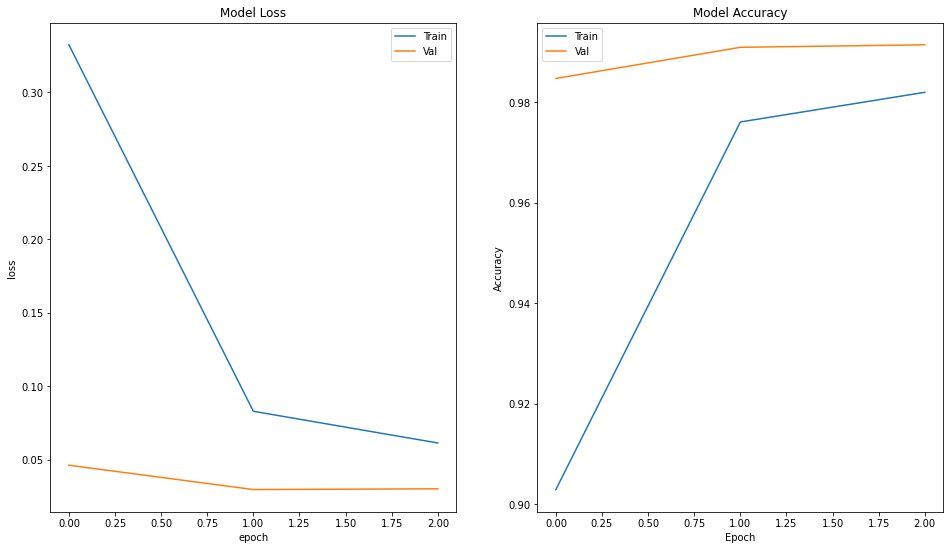

In [ ]:
"""
Description: Visualize model learning 
"""
fig, ax = plt.subplots(1, 2, figsize = (16, 9))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('Model Loss')
ax[0].legend(['Train', 'Val'], loc = 'best')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Val'], loc = 'best')

plt.show()

# 4.0 Prepare Data , Model and Label

In [ ]:

"""
Description: Save train data and label
"""
label=pd.DataFrame()
img_name = []
img_label = [] 
    
for i in range(X_val.shape[0]):
    cv2.imwrite(os.path.join(val_data_path_new,str(i)+".jpg") ,X_val[i]*255.0) # don't use plt.imread otheriwse while loading the saved images , and passing to model there is accuarcy drop 
    img_name.append(str(i)+".jpg")
    img_label.append(y_val[i])
label['image'] = img_name
label["label"] = np.array(img_label)

#write orig_label dataframe
label.to_csv(os.path.join(val_label_path,"val_label.csv"),index=False)

In [ ]:
"""
Description: Zip data
"""

make_archive(base_name="val_data",root_dir=val_data_path, base_dir = "val_data", zip_format='zip',is_dir=True)

In [ ]:
"""
Description: Zip label
"""
make_archive(base_name="val_label",root_dir=val_label_path,zip_format='zip')

In [ ]:
"""
Description: Zip models
"""
make_archive(base_name="clean_model1",root_dir=clean_model1_path,zip_format='zip')
make_archive(base_name="clean_model2",root_dir=clean_model2_path,zip_format='zip')
make_archive(base_name="fine_tuned_model",root_dir=fine_tuned_model_path,zip_format='zip')

# 5.0 AIShield API Call

In [ ]:
"""
Description: AIShield API URL and subscription key
""" 
baseurl = "XXXXXXXXXXXXXXXXXXXXXXXXXXX" # fill in API endpoint url from AIShield developer portal under API tab 
url=baseurl + "/api/ais/v1.5"
headers={'Cache-Control': 'no-cache',
'x-api-key': "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX", # fill in subscription key from AIShield developer portal under My Dashboard tab
'Org-Id' : "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"  # fill in Org_Id provided in welcome email
}

### 5.1 Model Registration

In [ ]:
"""
Description: call Model registration api to get unique model it and url to upload data, model and label
"""

model_registration_url = url + "/model_registration/upload" 
model_registration_payload = {
    'task_type':"IC",
    "analysis_type": "Poisoning"
}
new_request = requests.request(method="POST", url=model_registration_url, headers=headers, json=model_registration_payload)

new_request=json.loads(new_request.text)['data']

if 'data' in new_request.keys():
    model_id = new_request["model_id"]
    clean_model1_url = new_request["urls"]["clean_model1_upload_url"]
    clean_model2_url = new_request["urls"]["clean_model2_upload_url"]
    fine_tuned_model_url = new_request["urls"]["model_upload_url"]
    data_url = new_request["urls"]["data_upload_url"]
    label_url = new_request["urls"]["label_upload_url"]
    print('model_id: ', model_id)
else:
    for k, v in new_request.items():
        print("* {} : {}".format(k,v))

model_id:  4d437c67-c957-4306-a2bb-0c923f02f952


In [ ]:
"""
Description: Files path
"""
zip_path = os.getcwd()
data_path=os.path.join(zip_path,'val_data.zip')  # full path of data zip
label_path=os.path.join(zip_path,'val_label.zip') # full path of label zip
clean_model1_path=os.path.join(zip_path,'clean_model1.zip') # full path of model zip
clean_model2_path=os.path.join(zip_path,'clean_model2.zip') # full path of model zip
fine_tuned_model_path=os.path.join(zip_path,'fine_tuned_model.zip') # full path of model zip

In [ ]:
def upload_file(url, file_path):
    """
    url: URL to upload
    file_path: file to be uploaded
    """
    new_request = requests.request(method="PUT", url=url, data=open(file_path,'rb'))
    status_cd = new_request.status_code
    if status_cd == 200:
        status = 'upload successful'
    else:
        status = 'upload failed'
    return status

In [ ]:
"""
Description: Hit AIShield File Upload API
"""


label_upload_status = upload_file(label_url, label_path)
print('label_upload_status: ', label_upload_status)

data_upload_status = upload_file(data_url, data_path)
print('data_upload_status: ', data_upload_status)


clean_model1_upload_status = upload_file(clean_model1_url, clean_model1_path)
print('clean_model1_upload_status: ', clean_model1_upload_status)


clean_model2_upload_status = upload_file(clean_model2_url, clean_model2_path)
print('clean_model2_upload_status: ', clean_model2_upload_status)


fine_tuned_model_upload_status = upload_file(fine_tuned_model_url, fine_tuned_model_path)
print('fine_tuned_model_upload_status: ', fine_tuned_model_upload_status)


label_upload_status:  upload successful
data_upload_status:  upload successful
clean_model1_upload_status:  upload successful
clean_model2_upload_status:  upload successful
fine_tuned_model_upload_status:  upload successful


### 5.2 Model Analysis

In [ ]:

"""
Description: Payload for AIShield VulnerabilityReport api call
"""
payload={}
payload['model_id']= model_id 
payload['input_dimensions'] = "(28,28,1)"
payload['number_of_classes']= "10"
payload['model_framework']='tensorflow'
payload['vulnerability_threshold']="1"
payload['normalize_data']="yes"

In [ ]:
"""
Description: Hit AIShield VulnerabilityReport api
"""

model_analysis_url = url + "/model_analyse/{}".format(model_id)
if label_upload_status == "upload successful" and data_upload_status == "upload successful" and clean_model1_upload_status == "upload successful" and clean_model2_upload_status == "upload successful"  and fine_tuned_model_upload_status == "upload successful":
    new_request = requests.request(method="POST", url=model_analysis_url, json=payload,headers=headers)
    new_request=json.loads(new_request.text)
    for k, v in new_request.items():
        print("* {} : {}".format(k,v))

* api_version : 1.5
* job_id : XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
* monitor_link : XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [ ]:
"""
Description: Get job id from api response
"""
job_id=new_request['job_id']
print(f"Job id : {job_id}")

Job id : XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [ ]:
def monitor_api_progress(new_job_id):
        job_status_url = url + "/job_status_detailed?job_id="+ new_job_id

        # status dictionary
        status_dictionary = {
            'ModelExploration_Status': 'na',
            'SanityCheck_Status': 'na',
            'VunerabilityEngine_Status': 'na',
            'DefenseReport_Status': 'na',
        }
        counts = [0] * len(status_dictionary)
        failed_api_hit_count = 0
        while True:
            time.sleep(2)
            try:
                job_status_response = requests.request("GET", job_status_url, params={},
                                                       headers=headers)

                job_status_payload = json.loads(job_status_response.text)
                failing_key = 'ModelExploration_Status'
                for i, key in enumerate(status_dictionary.keys()):
                    if status_dictionary[key] == 'na':
                        if job_status_payload[key] == 'inprogress' and status_dictionary[key] == 'na':
                            status_dictionary[key] = job_status_payload[key]
                            print(str(key), ":", status_dictionary[key])

                        elif job_status_payload[key] == 'completed' or job_status_payload[key] == 'passed':
                            status_dictionary[key] = job_status_payload[key]
                            counts[i] += 1
                            print(str(key), ":", status_dictionary[key])

                        if job_status_payload[key] == 'failed':
                            failing_key = key
                            status_dictionary[key] = job_status_payload[key]
                            print(str(key), ":", status_dictionary[key])

                    elif job_status_payload[key] == 'completed' or job_status_payload[key] == 'passed':
                        status_dictionary[key] = job_status_payload[key]
                        if counts[i] < 1:
                            print(str(key), ":", status_dictionary[key])
                        counts[i] += 1

                    else:
                        if job_status_payload[key] == 'failed':
                            failing_key = key
                            status_dictionary[key] = job_status_payload[key]
                            print(str(key), ":", status_dictionary[key])

                if job_status_payload[failing_key] == 'failed':
                    break

                if status_dictionary['VunerabilityEngine_Status'] == 'passed' or status_dictionary[
                    'VunerabilityEngine_Status'] == 'completed' and job_status_payload[
                    'CurrentStatus'] == "Defense generation is not triggered":
                    print("\n Vulnerability score {} failed to cross vulnerability threshold of {}".format(
                        job_status_payload['VulnerabiltyScore'], payload['vulnerability_threshold']))
                    break
                if job_status_payload['DefenseReport_Status'] == 'completed':
                    break
            except Exception as e:
                failed_api_hit_count += 1
                print("Error {}. trying {} ...".format(str(e), failed_api_hit_count))
                if failed_api_hit_count >= 3:
                    break
        return status_dictionary

In [ ]:
"""
Description: Continuos monitoring of jod progress
"""
status_dictionary = monitor_api_progress(new_job_id=job_id)

ModelExploration_Status : completed
SanityCheck_Status : passed
VunerabilityEngine_Status : completed

 Vulnerability score 1.00 failed to cross vulnerability threshold of 1


In [ ]:
def download_artifact(job_id, report_type='Vulnerability', file_format=0):
    """
    job_id: job_id  received after successful api call
    report_type: report to be downloaded
    file_format: change file_format to : 0- all report in zip 
                        1- report in .txt 
                        2- report in .pdf
                        3- report in .json
                        4- report in .xml
    """
    
    print("received report_type : {} and file format is: {}".format(report_type, file_format))
    report_url = url + "/" + "get_report?job_id=" + str(
        job_id) + "&report_type=" + report_type + "&file_format=" + str(file_format)

    headers1=headers
    headers1["content-type"]= "application/zip"

    response = requests.request("GET", report_url, params={}, headers=headers1)

    if file_format == 0:
        with open(os.path.join(report_path, report_type + ".zip"), 'wb') as f:
            f.write(response.content)
    elif file_format == 1:
        with open(os.path.join(report_path, report_type + ".txt"), 'wb') as f:
            f.write(response.content)
    elif file_format == 2:
        with open(os.path.join(report_path, report_type + ".pdf"), 'wb') as f:
            f.write(response.content)
    elif file_format == 3:
        with open(os.path.join(report_path, report_type + ".json"), 'wb') as f:
            f.write(response.content)
    elif file_format == 4:
        with open(os.path.join(report_path, report_type + ".xml"), 'wb') as f:
            f.write(response.content)

In [ ]:
"""
Description: download generated artifact
"""
if status_dictionary["VunerabilityEngine_Status"] == 'completed':
    download_artifact(job_id=job_id, report_type='Vulnerability', file_format=2) 


received report_type : Vulnerability and file format is: 2
